# ``GaLeSS`` (Galaxy Lenses Search Statistics)

### This notebook provides some examples of the uses of the ``GaLeSS`` module.

### You can find more plots like the one shown below described in detail in [Ferrami & Wyithe 2024](https://arxiv.org/>)

First, let's import the relevant modules and initialise the phase space we are interested in probing.

``GaLeSS`` works by estimating the number of galaxies in a survey by sampling the lens and source populations.<br>
The lens population is characterised by range of lens masses (represented by theirs velocity dispersions) and redshifts.<br>
The source population is represented by a Luminosity Function (LF) sampled over a range of intrisic UV magnitudes and evolving with redshift.

In [3]:
import os, sys
import numpy as np

path_root = os.path.split(os.path.abspath(''))[0]
sys.path.append(str(path_root) + '/galess/LensStat/')
sys.path.append(str(path_root) + '/galess/Utils/')
sys.path.append(str(path_root) + '/galess/Plots/')
import lens_stat as ls
import ls_utils as utils
import lens_plot

M_array     = np.linspace(-13 , -25 , 25)
sigma_array = np.linspace(100 , 400 , 31)
zl_array    = np.arange(0.  , 2.5 , 0.1)
zs_array    = np.arange(0.  , 5.4 , 0.2)

Each combination of survey - photometric band has a ``.param`` file in the ``data/survey_params`` folder in this repo,<br>
which contains the relevant input parameters to ``GaLeSS``.<br>
Here is the list of the file headers:

In [4]:
surveys_titles = [
     'COSMOS HST i band',
     'CFHTLS i band',
     'SUBARU HSC SuGOHI i band',
     'DES i band',
     'COSMOS Web F115W', 'COSMOS Web F150W', 'COSMOS Web F277W',
     'PEARLS NEP F115W', 'PEARLS NEP F150W', 'PEARLS NEP F277W',
     'EUCLID Wide VIS', 'EUCLID Wide Y', 'EUCLID Wide J', 'EUCLID Wide H',
     'Roman HLWA J',
     'LSST i band', 'LSSTsinglevisit i band']

Here is an example of such parameters contained in `EUCLID Wide VIS.param`:
```python
{
title: 'EUCLID Wide VIS'
limit: 26.2
cut: 25
area: 15000
seeing: 0.17
exp_time_sec: 1610
pixel_arcsec: 0.1
zero_point_m: 25.5
sky_bckgnd_m: 22.2
photo_band: 'sdss_i0'
}
```
<br>
<br>
Other two input parameters we need to provide are the minimal value of signal-to-noise and magnification<br>
at which a lens becomes identifiable.<br>
To remain consistent with some of the past literature ion the topic, we choose:

In [5]:
min_SNR     = 20
arc_mu_thr  = 3

We can now run the model using the input parameters we discussed so far.<br>
The only missing information is whether we want to estimate a lens search in which the lens galaxy light profile is completely removed,<br>
or accounting for its foreground light. This is controlled by the `LENS_LIGHT_FLAG`.<br>
(There is one last ingredient to the recipe, the assumed Velocity Dispersion Function, or VDF, but we'll discuss it later).<br><br>
Below is a sample run on the `LSST i band`, try to change it to `COSMOS Web F115W`!<br>

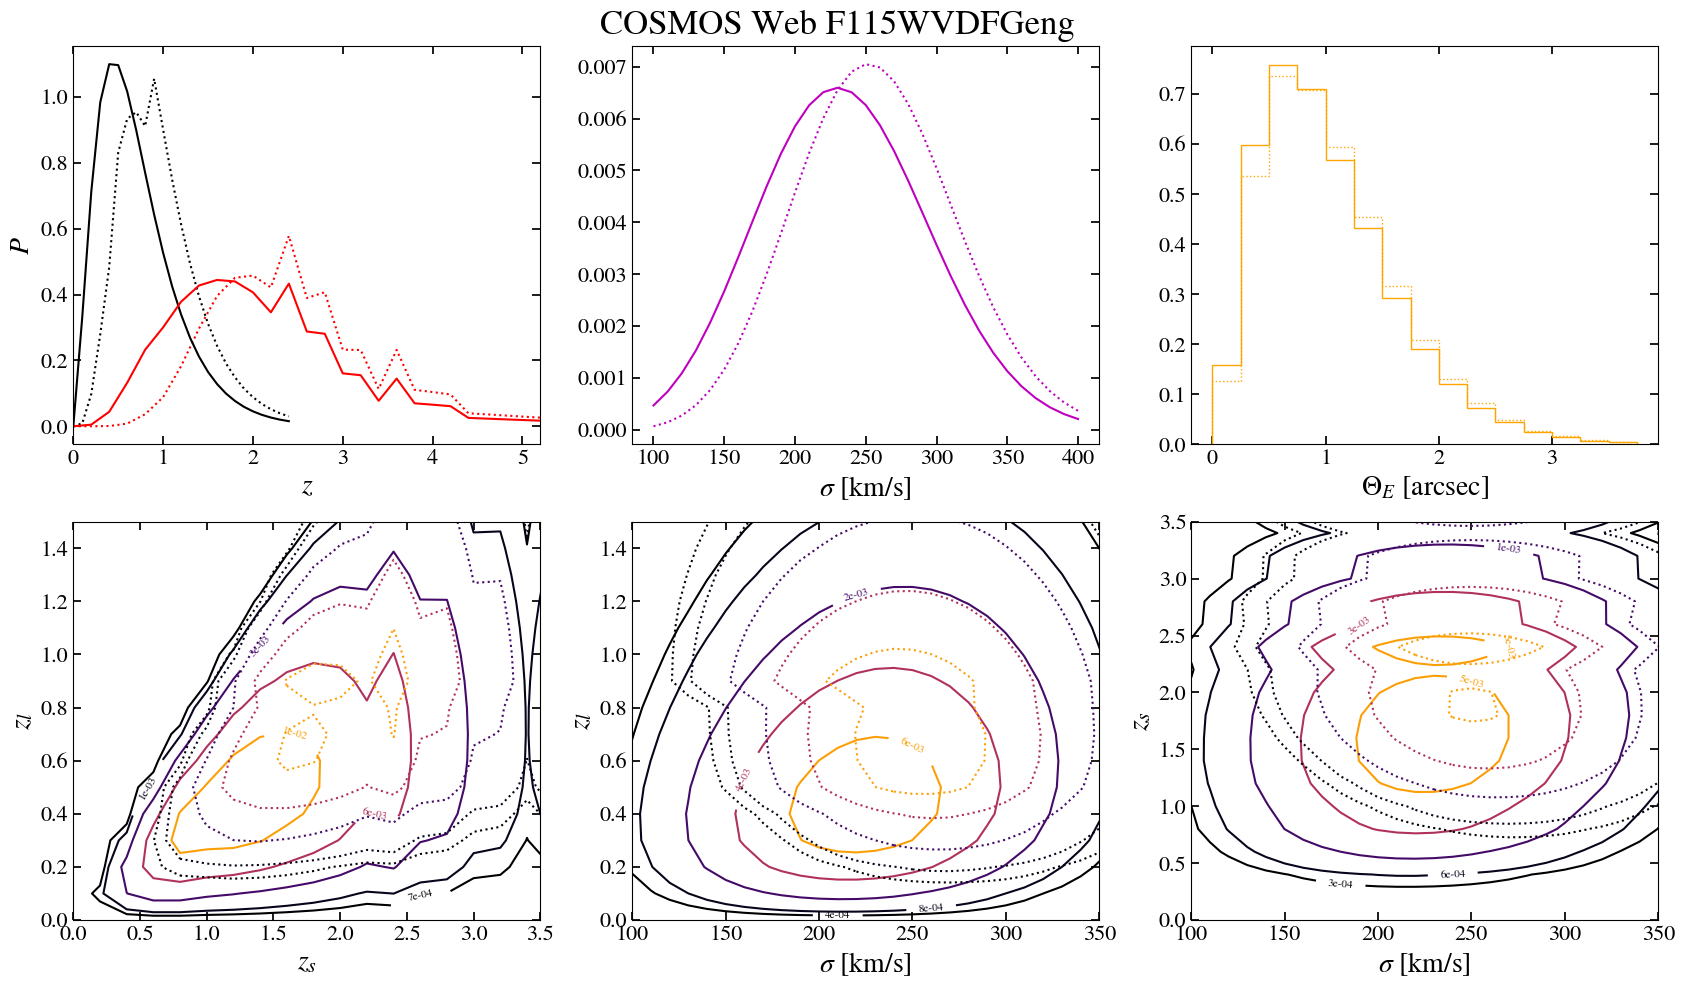

In [46]:
for title in ['COSMOS Web F115W']: #Try 'COSMOS Web F115W'!
     survey_params = utils.read_survey_params(title, VERBOSE = 0)
     limit    = survey_params['limit']
     cut      = survey_params['cut']
     area     = survey_params['area']
     seeing   = survey_params['seeing']
     exp_time_sec = survey_params['exp_time_sec']
     zero_point_m = survey_params['zero_point_m']
     sky_bckgnd_m = survey_params['sky_bckgnd_m']
     photo_band   = survey_params['photo_band']

     VDF = ls.Phi_vel_disp_Geng
     if VDF == ls.Phi_vel_disp_Geng: title = title + 'VDFGeng'

     try:
          matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL = utils.load_pickled_files(title)
     except ValueError:
          print('FILE do NOT exist - RUNNING MODEL')
          matrix_noLL, Theta_E_noLL, prob_noLL = ls.calculate_num_lenses_and_prob(
                                                  sigma_array, zl_array, zs_array, M_array, limit, area,
                                                  seeing, min_SNR, exp_time_sec, sky_bckgnd_m, zero_point_m,
                                                  photo_band = photo_band, mag_cut=cut, arc_mu_threshold = arc_mu_thr,
                                                  Phi_vel_disp = VDF, LENS_LIGHT_FLAG = False)
          matrix_LL, Theta_E_LL, prob_LL = ls.calculate_num_lenses_and_prob(
                                                  sigma_array, zl_array, zs_array, M_array, limit, area,
                                                  seeing, min_SNR, exp_time_sec, sky_bckgnd_m, zero_point_m,
                                                  photo_band = photo_band, mag_cut=cut, arc_mu_threshold = arc_mu_thr,
                                                  Phi_vel_disp = VDF, LENS_LIGHT_FLAG = True)
          utils.save_pickled_files(title,  matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL)

     lens_plot.plot_ALL_distributions(title, zl_array, zs_array, sigma_array,
                                   Theta_E_LL, matrix_LL, Theta_E_noLL, matrix_noLL,
                                   PLOT_FOR_KEYNOTE = 0, SMOOTH = 0, SAVE = 0)

With this setup, we can now compute the surveys we want, and store it for faster plotting later.<br>
There is also an utility function that prints a summary of the model results for each survey:

In [7]:
utils.print_summary_surveys(['LSST i band', 'COSMOS HST i band'])

|     Survey - Filter     | PSF/Seeing ["] | Area [deg^2] | m_cut [mag] | m_lim [mag] | N [deg^-1] | N_lenses (LL)       |

|       LSST i band       |           0.710|     20000.000|         26.4|         26.4|          37|  7.4e+05 (  5.2e+05)|

|    COSMOS HST i band    |           0.120|         1.600|         25.0|         26.5|          27|       44 (       22)|



Here we compare the 1-D probability distributions over redshift, velocity dispersion and Einstein Radius for a set of surveys.

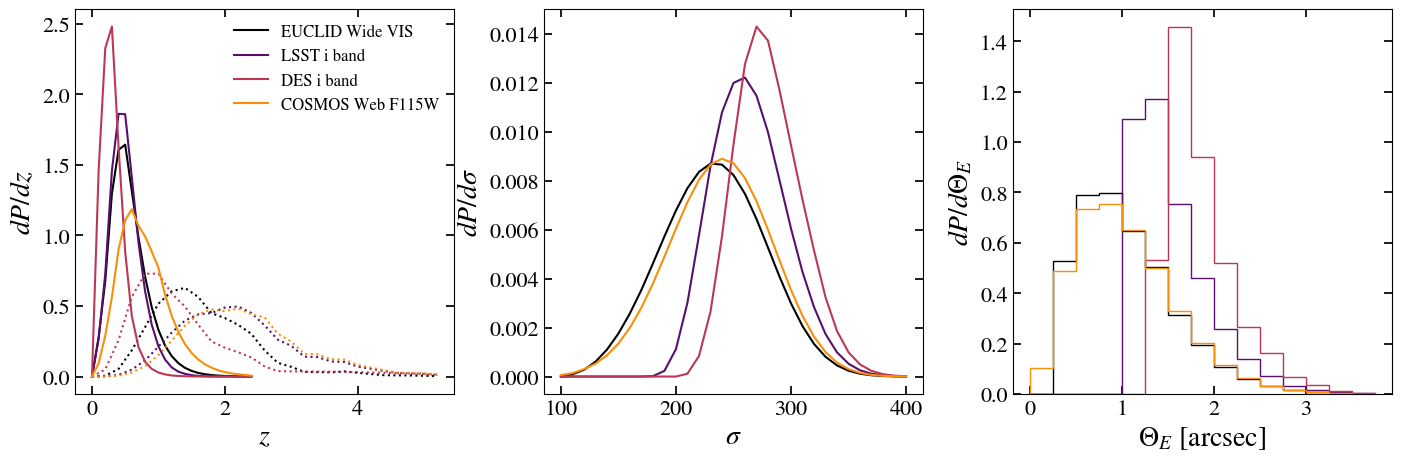

In [8]:
surveys_selection = ['EUCLID Wide VIS', 'LSST i band', 'DES i band', 'COSMOS Web F115W']
lens_plot.compare_ALL_distributions_surveys(surveys_selection, sigma_array, zl_array, zs_array)

### ``MODEL RESPONSE TO INPUT PARAMETERS:`` <span style="color: orange"> VDF </span>
As briefly mentioned above, the assumption made on the lens mass distribution and evolution with redshift,<br>
represented by the Velocity Dispersion Funcition (VDF), is an important input in our model, which at the moment<br>
is not very well constrained at all.<br>
<br>
Here is a plot that shows the prediction fot `EUCLID Wide VIS` with no lens light for 3 different choices of VDF:

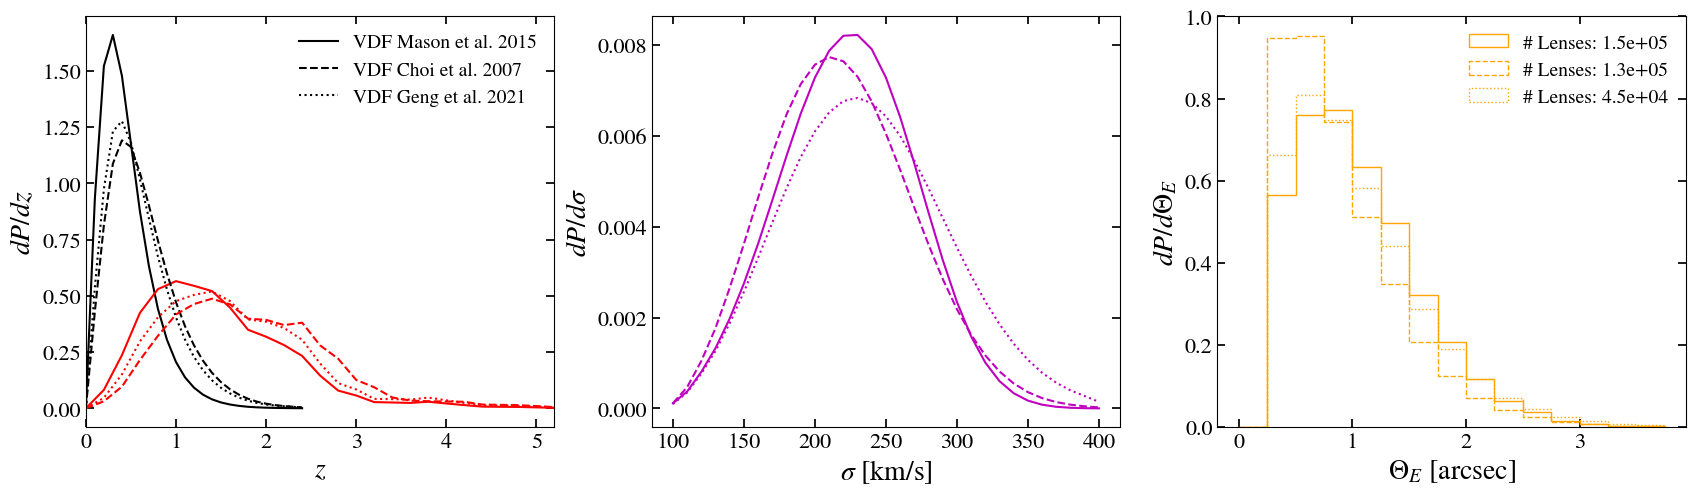

In [2]:
#Comparing the effect of vel disp functions
lens_plot.plot_effect_vel_disp_function(zl_array, zs_array, sigma_array, LENS_LIGHT = 0, SMOOTH = 1, READ_FILES = 1, SAVE=1)

### ``MODEL RESPONSE TO INPUT PARAMETERS:`` <span style="color: orange"> m<sub>cut</sub></span> 

Another example of the model response to input parameters is the cut in magnitude m<sub>cut</sub> imposed on the survey data.
Shown below is the effect of m<sub>cut</sub> on the 1-D distributions and on the total number of lenses.


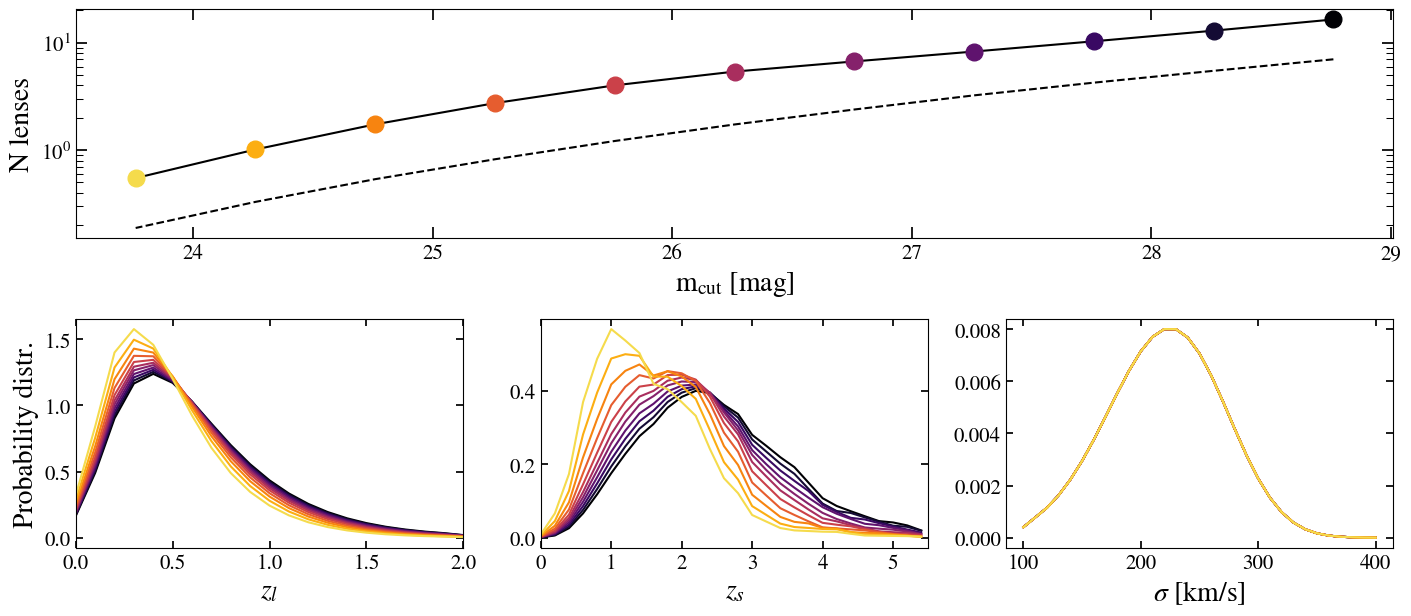

In [8]:
lens_plot.model_response_m_cut()

### ``TESTING AGAINST OBSERVED LENS SAMPLES``

``GaLeSS`` can be used to compare models with varying input parameters to past lens searches.<br>
Here we show the full SL2S sample from [Sonnenfeld et al. 2013](http://dx.doi.org/10.1088/0004-637X/777/2/98) with ``GaLeSS`` output with two different VDF as a input.

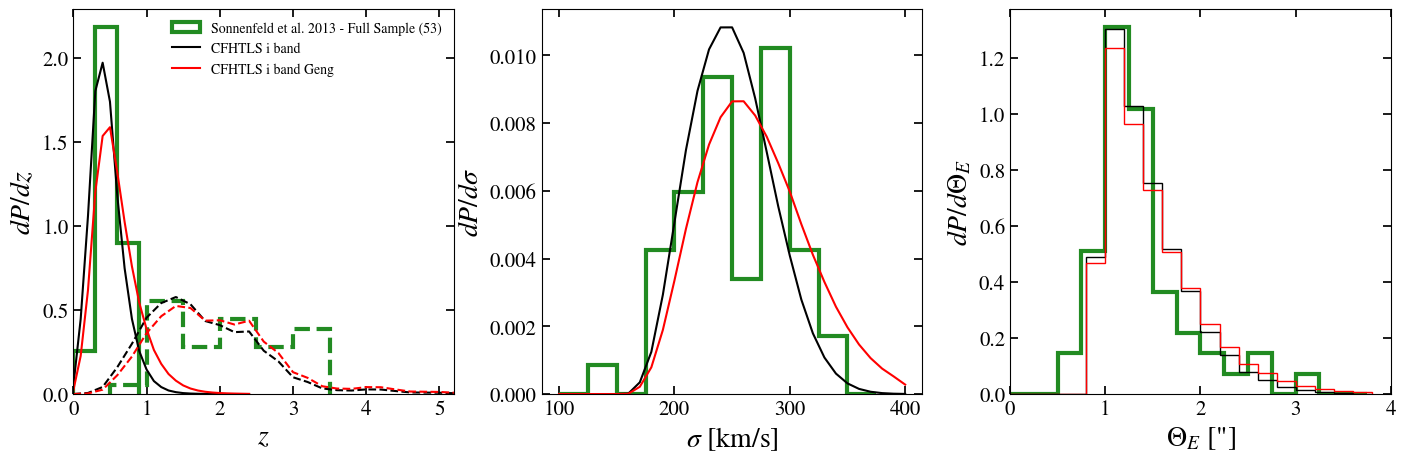

In [11]:
lens_plot.compare_SL2S(zl_array, zs_array, sigma_array, LENS_LIGHT = 1)